In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vision Workshop - Model Experimentation

## Overview

[Vision Workshop](https://github.com/mblanc/vision-workshop) is a series of labs on how to build an image classification system on Google Cloud. Throughout the Vision Workshop labs, you will learn how to read image data stored in data lake, perform exploratory data analysis (EDA), train a model, register your model in a model registry, evaluate your model, deploy your model to an endpoint, do real-time inference on your model.

### Objective

This notebook shows how to pull features from Feature Store for training, run data exploratory analysis on features, build a machine learning model locally, experiment with various hyperparameters, evaluate the model and deloy it to a Vertex AI endpoint. 

This lab uses the following Google Cloud services and resources:

- [Vertex AI](https://cloud.google.com/vertex-ai/)

Steps performed in this notebook:

- Use a Feature Store to pull training data
- Do some exploratory analysis on the extracted data
- Train the model and track the results using Vertex AI Experiments

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* BigQuery

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [BigQuery pricing](https://cloud.google.com/bigquery/pricing) and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Load configuration settings from the setup notebook

Set the constants used in this notebook and load the config settings from the `00_environment_setup.ipynb` notebook.

In [1]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
BUCKET_NAME = f"{PROJECT_ID}-vision-workshop"
config = !gsutil cat gs://{BUCKET_NAME}/config/notebook_env.py
print(config.n)
exec(config.n)


BUCKET_NAME          = "temp-vision-workshop-vision-workshop"
PROJECT              = "temp-vision-workshop"
REGION               = "europe-west4"
ID                   = "7l3oe"
MODEL_NAME           = "vision_workshop_model"
ENDPOINT_NAME        = "vision_workshop_endpoint"



### Mount Google Cloud Storage with gcsfuse

Todo

In [2]:
!fusermount -u /home/jupyter/gcs/{BUCKET_NAME}
!rm -rf ~/gcs

In [3]:
!mkdir -p ~/gcs/{BUCKET_NAME}

In [4]:
!gcsfuse --implicit-dirs {BUCKET_NAME} /home/jupyter/gcs/{BUCKET_NAME}

2022/11/16 15:34:55.044445 Start gcsfuse/0.41.8 (Go version go1.18.4) for app "" using mount point: /home/jupyter/gcs/temp-vision-workshop-vision-workshop
2022/11/16 15:34:55.063078 Opening GCS connection...
2022/11/16 15:34:55.208301 Mounting file system "temp-vision-workshop-vision-workshop"...
2022/11/16 15:34:55.212611 File system has been successfully mounted.


In [5]:
!ls -lh ~/gcs/{BUCKET_NAME}

total 226K
-rw-r--r-- 1 jupyter jupyter 3.1K Nov  9 15:29 aiplatform-2022-11-09-15:29:41.397-aiplatform_custom_trainer_script-0.1.tar.gz
-rw-r--r-- 1 jupyter jupyter 3.1K Nov  9 15:29 aiplatform-2022-11-09-15:29:59.482-aiplatform_custom_trainer_script-0.1.tar.gz
-rw-r--r-- 1 jupyter jupyter 3.0K Nov  9 16:51 aiplatform-2022-11-09-16:51:32.073-aiplatform_custom_trainer_script-0.1.tar.gz
-rw-r--r-- 1 jupyter jupyter 3.0K Nov 10 12:58 aiplatform-2022-11-10-12:58:02.558-aiplatform_custom_trainer_script-0.1.tar.gz
drwxr-xr-x 1 jupyter jupyter    0 Nov 16 15:34 aiplatform-custom-training-2022-11-07-20:04:26.326
drwxr-xr-x 1 jupyter jupyter    0 Nov 16 15:34 aiplatform-custom-training-2022-11-07-20:07:58.686
drwxr-xr-x 1 jupyter jupyter    0 Nov 16 15:34 aiplatform-custom-training-2022-11-07-20:11:10.825
drwxr-xr-x 1 jupyter jupyter    0 Nov 16 15:34 aiplatform-custom-training-2022-11-07-20:14:17.733
drwxr-xr-x 1 jupyter jupyter    0 Nov 16 15:34 aiplatform-custom-training-2022-11-08-09:39:30

In [6]:
import pathlib
data_dir = pathlib.Path(f"/home/jupyter/gcs/{BUCKET_NAME}/prod/")

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


### Import libraries

In [8]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import time
from datetime import datetime, timedelta
from google.cloud import aiplatform as vertex_ai

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-11-16 15:35:13.908444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 15:35:13.994052: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 15:35:13.995807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [10]:
# #General
# import os
# import sys
# from typing import Union, List
# import random
# from datetime import datetime, timedelta
# import time
# import json
# import logging

# #Feature Store
# from google.cloud import aiplatform as vertex_ai
# from google.cloud.aiplatform import Featurestore, EntityType, Feature

# #Data Preprocessing
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline

# #Model Training
# from google.cloud import bigquery
# from google.cloud import storage
# from sklearn import metrics
# from sklearn.metrics import precision_recall_fscore_support
# from sklearn.metrics import classification_report, f1_score, accuracy_score
# from sklearn.linear_model import LogisticRegression

### Define constants

In [11]:
TIMESTAMP = str(int(time.time()))

## Experiment
EXPERIMENT_NAME = "fd-experiment-" + TIMESTAMP

In [12]:
# TIMESTAMP = str(int(time.time()))

# # General
# DATA_DIR = os.path.join(os.pardir, "data")
# TRAIN_DATA_DIR = os.path.join(DATA_DIR, "train")
# DATA_URI = f"gs://{BUCKET_NAME}/data"
# TRAIN_DATA_URI = f"{DATA_URI}/train"
# CONFIG_URI =  f"gs://{BUCKET_NAME}/config" 
# BQ_DATASET = "tx"

# # Feature Store
# START_DATE_TRAIN = (datetime.today() - timedelta(days=1)).strftime("%Y-%m-%d")
# END_DATE_TRAIN = (datetime.today() - timedelta(days=1)).strftime("%Y-%m-%d")
# EVENTS_TABLE_NAME = f"events_{END_DATE_TRAIN}"
# CUSTOMERS_TABLE_NAME = f"customers_{END_DATE_TRAIN}"
# TERMINALS_TABLE_NAME = f"terminals_{END_DATE_TRAIN}"
# CUSTOMER_ENTITY = "customer"
# TERMINAL_ENTITY = "terminal"
# SERVING_FEATURE_IDS = {CUSTOMER_ENTITY: ["*"], TERMINAL_ENTITY: ["*"]}
# READ_INSTANCES_TABLE = f"ground_truth_{END_DATE_TRAIN.replace('-', '')}"
# READ_INSTANCES_URI = f"bq://{PROJECT_ID}.tx.{READ_INSTANCES_TABLE}"

# # Training
# COLUMNS_IGNORE = ["terminal_id", "customer_id", "entity_type_event", "entity_type_customer", "entity_type_terminal"]
# TARGET = "tx_fraud"

# # Custom Training
# DATASET_NAME=f"sample_train-{ID}-{END_DATE_TRAIN}"
# TRAIN_JOB_NAME=f"fraudfinder_xgb_train_expr-{ID}-{TIMESTAMP}"
# MODEL_NAME=f"fraudfinder_xgb_model_expr-{ID}-{TIMESTAMP}"
# DEPLOYED_NAME = f"fraudfinder_xgb_prediction_expr-{ID}-{TIMESTAMP}"

# ## Experiment
# EXPERIMENT_NAME = "fd-experiment-" + TIMESTAMP

### Initialize clients

In [13]:
vertex_ai.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_NAME, experiment=EXPERIMENT_NAME)

## Fetching feature values for model training

To fetch training data, TODO


In [33]:
import pathlib
data_dir = pathlib.Path(f"/home/jupyter/gcs/{BUCKET_NAME}/prod")

In [34]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [35]:
batch_size = 32
img_height = 384
img_width = 384

In [46]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 6 classes.
Using 2936 files for training.


In [47]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 6 classes.
Using 734 files for validation.


### Data exploration
Here we use a subset of data for data exploration and better understanding of the data.

In [48]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(train_ds.class_names)

['daisy', 'dandelion', 'flowers', 'roses', 'sunflowers', 'tulips']


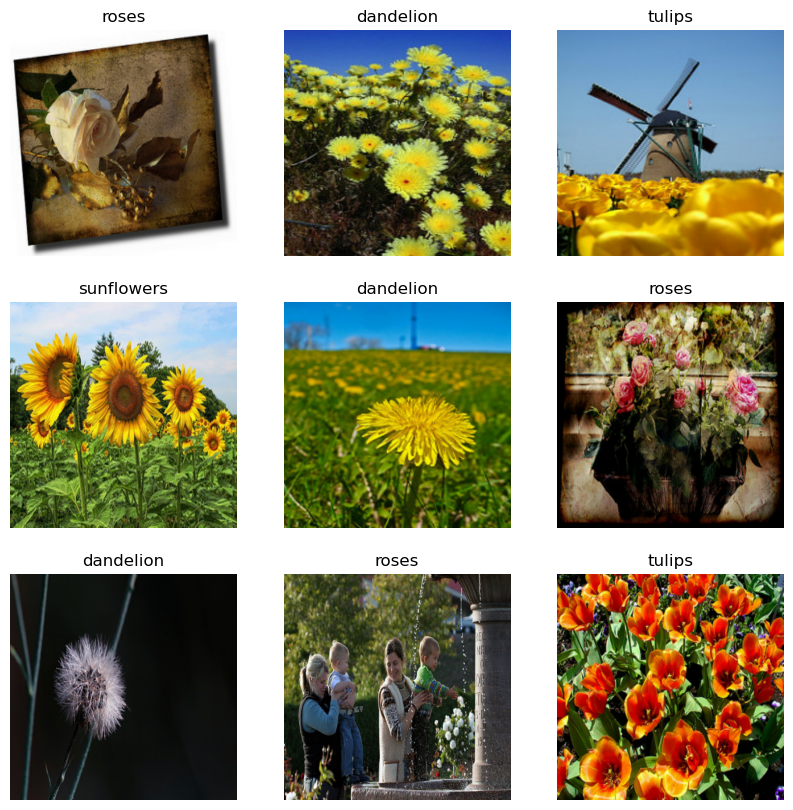

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [50]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"), 
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomTranslation(0, 0.2),
        tf.keras.layers.RandomTranslation(0.2, 0),
        tf.keras.layers.RandomZoom(0.2, 0.2),
    ]
)

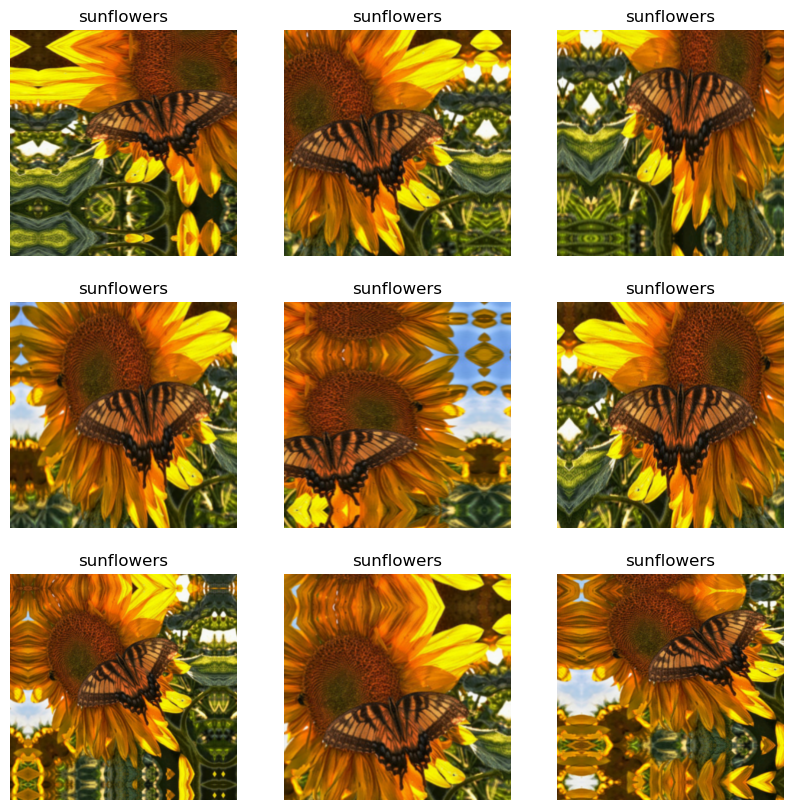

In [51]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(train_ds.class_names[int(labels[0])])
        plt.axis("off")

**Some Observations**

Based on this simple exploratory data analysis (EDA) of the sample:

- The sample is unbalanced.
- We should probably discard some variables with little predictive value.
- We might want to extract subsets of the timestamp into separate features such as day, week, night, etc. (i.e. calculate some time-based embeddings).
- We may want to do some variable selection.
- We'll need to scale some variables.

## Builing a custom model

### Fixing an imbalanced dataset
In the real world, we need to deal with imbalance in our dataset. For example, we might randomly delete some of the non-fraudulent transcations in order to approximately match the number of fraudulent transactions. This technique is called undersampling. 

For this workshop, we will skip the data balance process, because our sample data is small and further reduction will compromise the quality of our results. If you have a larger sample and would like to balance your data, you can uncomment and run the following cell.

In [52]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Training
In this section, we will train a model using the xgboost algorithm. Typically, to perform training, you might want to use a Vertex AI traning pipeline, however, as we are experimenting here, we simply use the xgboost package interactively to train our model in this notebook. 

#### Why XGBoost?
Extreme gradient-boosted (XGBoost) algorithm is a ML algorithm based on ensembles of decision trees, that works well with imbalanced data, handleing missing values, and can speed up through parallel-processing.

In [53]:
def get_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(img_height, img_width, 3)),
        data_augmentation, 
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(16, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
    ])
    return model

def get_pretrained_model():
    base_model = tf.keras.applications.EfficientNetV2S(
        weights="imagenet",  # Load weights pre-trained on ImageNet.
        input_shape=(img_height, img_width, 3),
        include_top=False,
    )  # Do not include the ImageNet classifier at the top.

    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)  # Apply random data augmentation

    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = tf.keras.layers.Dense(num_classes)(x)
    model = tf.keras.Model(inputs, outputs)
    return model

def get_tfhub_model():
    base_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2", trainable=False)
    #  base_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2", trainable=False)

    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)  # Apply random data augmentation
    x = tf.keras.layers.Rescaling(1./255)(x)

    # The base model contains batchnorm layers. We want to keep them in inference mode
    # when we unfreeze the base model for fine-tuning, so we make sure that the
    # base_model is running in inference mode here.
    x = base_model(x)
    #x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = tf.keras.layers.Dense(num_classes)(x)
    model = tf.keras.Model(inputs, outputs)
    
    return model
    
model = get_tfhub_model()

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 384, 384, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 384, 384, 3)       0         
                                                                 
 keras_layer_2 (KerasLayer)  (None, 1280)              20331360  
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 20,339,046
Trainable params: 7,686
Non-traina

#### Training the model
Before running XGBoost, we can set some hyperparameters, which has a strong impact on XGBoost performance. As a best practice, you can use Vertex AI HyperParameter Tuning to automatically find the best parameters. However, in this notebook, for the sake of simplicity and expedience, we specify these hyperparemeters manually and randomly. 

- Eta is a regularization parameter to reduce feature weights in each boosting step. 
- Gamma is a regularization parameter for tree pruning.
- Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. 


For more information about parameters check [this document](https://xgboost.readthedocs.io/en/stable/parameter.html).

In [54]:
epochs=20


run_name=f"local-run-8"
print(run_name)
# vertex_ai.start_run(run=run_name)
# vertex_ai.log_params({"type": "efficientnet"})

local-run-8


In [55]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.0001)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  # callbacks=[reduce_lr]
)

Epoch 1/20
92/92 [==============================] - 61s 504ms/step - loss: 0.5490 - accuracy: 0.8116 - val_loss: 0.2776 - val_accuracy: 0.8978
Epoch 2/20
92/92 [==============================] - 39s 425ms/step - loss: 0.3204 - accuracy: 0.8958 - val_loss: 0.2375 - val_accuracy: 0.9087
Epoch 3/20
92/92 [==============================] - 38s 417ms/step - loss: 0.2682 - accuracy: 0.9131 - val_loss: 0.2241 - val_accuracy: 0.9074
Epoch 4/20
92/92 [==============================] - 39s 421ms/step - loss: 0.2454 - accuracy: 0.9210 - val_loss: 0.2064 - val_accuracy: 0.9305
Epoch 5/20
92/92 [==============================] - 38s 419ms/step - loss: 0.2284 - accuracy: 0.9220 - val_loss: 0.1957 - val_accuracy: 0.9332
Epoch 6/20
92/92 [==============================] - 38s 419ms/step - loss: 0.2185 - accuracy: 0.9257 - val_loss: 0.1953 - val_accuracy: 0.9292
Epoch 7/20
92/92 [==============================] - 39s 419ms/step - loss: 0.2201 - accuracy: 0.9210 - val_loss: 0.1899 - val_accuracy: 0.9278

In [56]:
round(model.optimizer.lr.numpy(), 5)

0.003

In [57]:
loss, accuracy = model.evaluate(val_ds)
# vertex_ai.log_metrics({"loss": loss, "accuracy": accuracy})


23/23 [==============================] - 8s 328ms/step - loss: 0.1881 - accuracy: 0.9305


In [58]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


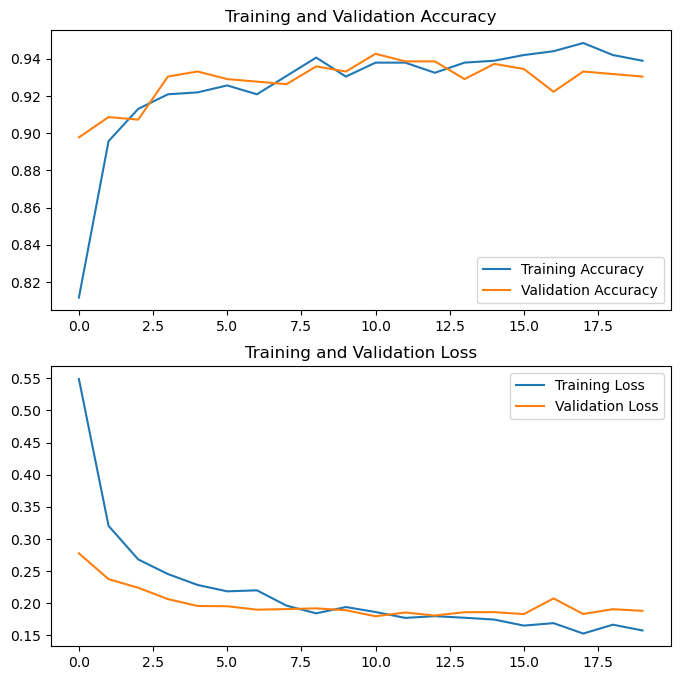

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [60]:
#vertex_ai.end_run()

In [61]:
experiment_df = vertex_ai.get_experiment_df()
experiment_df

""


In [62]:
print("Vertex AI Experiments:")
print(
    f"https://console.cloud.google.com/ai/platform/experiments/experiments?folder=&organizationId=&project={PROJECT_ID}"
)

Vertex AI Experiments:
https://console.cloud.google.com/ai/platform/experiments/experiments?folder=&organizationId=&project=temp-vision-workshop


In [64]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 94.57 percent confidence.


In [ ]:
# parameters = [
#     {"type": "efficientnet", "img_size": 384, "batch_size": 8, "dropout": True, "trainable": True, "epochs": 5},
# ]

# models={}
# for i, params in enumerate(parameters):
#     batch_size = params["batch_size"]
#     img_height = params["img_size"]
#     img_width = params["img_size"]
    
#     train_ds = tf.keras.utils.image_dataset_from_directory(
#   data_dir,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(img_height, img_width),
#   batch_size=batch_size)
    
    
    
#     run_name=f"fd-xgboost-local-run-{i}"
#     print(run_name)
#     vertex_ai.start_run(run=run_name)
#     vertex_ai.log_params(params)
#     model =  xgb.XGBClassifier( objective="reg:logistic", max_depth = params["max_depth"], gamma = params["gamma"], eta = params["eta"], use_label_encoder=False)
#     model.fit(x_train, y_train)
#     models[run_name] = model
#     y_pred_proba = model.predict_proba(x_val)[:, 1]
#     y_pred = model.predict(x_val)
#     acc_score = accuracy_score(y_val, y_pred)
#     val_f1_score = f1_score(y_val, y_pred, average="weighted")
#     vertex_ai.log_metrics({"acc_score": acc_score, "f1score": val_f1_score})
#     vertex_ai.end_run()

#### Save model
Now that we have run our experiments, lets choose one of the experiments, and use xgboost.Booster's `save_model` method to export the model to a local file named `model.bst`.

In [37]:
model_directory = "../models"
!sudo mkdir -p -m 777 {model_directory}
model.save(model_directory)

INFO:tensorflow:Assets written to: ../models/assets


INFO:tensorflow:Assets written to: ../models/assets


## AutoML

In [65]:
from google.cloud import storage

client = storage.Client() 

# Implicit environment set up
# with explicit set up:
# client = storage.Client.from_service_account_json('key-file-location')

blobs = list(client.list_blobs(BUCKET_NAME, prefix='prod/'))

In [66]:
labels = [os.path.split(os.path.dirname(blob.name))[1] for blob in blobs]

In [67]:
d = [[f"gs://{blob.bucket.name}/{blob.name}", os.path.split(os.path.dirname(blob.name))[1]] for blob in blobs]

In [68]:
import pandas as pd

In [69]:
df = pd.DataFrame(d)
df

,0,1
0,gs://temp-vision-workshop-vision-workshop/prod...,prod
1,gs://temp-vision-workshop-vision-workshop/prod...,prod
2,gs://temp-vision-workshop-vision-workshop/prod...,prod
3,gs://temp-vision-workshop-vision-workshop/prod...,prod
4,gs://temp-vision-workshop-vision-workshop/prod...,daisy
...,...,...
3685,gs://temp-vision-workshop-vision-workshop/prod...,tulips
3686,gs://temp-vision-workshop-vision-workshop/prod...,tulips
3687,gs://temp-vision-workshop-vision-workshop/prod...,tulips
3688,gs://temp-vision-workshop-vision-workshop/prod...,tulips


In [70]:
df.to_csv(f"gs://{BUCKET_NAME}/prod/flowers.csv",index=False, header=False)

In [71]:
ds = vertex_ai.ImageDataset.create(
    display_name="flowers_prod",
    gcs_source=f"gs://{BUCKET_NAME}/prod/flowers.csv",
    import_schema_uri=vertex_ai.schema.dataset.ioformat.image.single_label_classification,
    sync=True,
)

ds.wait()

print(ds.display_name)
print(ds.resource_name)

Creating ImageDataset


INFO:google.cloud.aiplatform.datasets.dataset:Creating ImageDataset


Create ImageDataset backing LRO: projects/446303513828/locations/europe-west4/datasets/4379471361664352256/operations/8619936416031309824


INFO:google.cloud.aiplatform.datasets.dataset:Create ImageDataset backing LRO: projects/446303513828/locations/europe-west4/datasets/4379471361664352256/operations/8619936416031309824


ImageDataset created. Resource name: projects/446303513828/locations/europe-west4/datasets/4379471361664352256


INFO:google.cloud.aiplatform.datasets.dataset:ImageDataset created. Resource name: projects/446303513828/locations/europe-west4/datasets/4379471361664352256


To use this ImageDataset in another session:


INFO:google.cloud.aiplatform.datasets.dataset:To use this ImageDataset in another session:


ds = aiplatform.ImageDataset('projects/446303513828/locations/europe-west4/datasets/4379471361664352256')


INFO:google.cloud.aiplatform.datasets.dataset:ds = aiplatform.ImageDataset('projects/446303513828/locations/europe-west4/datasets/4379471361664352256')


Importing ImageDataset data: projects/446303513828/locations/europe-west4/datasets/4379471361664352256


INFO:google.cloud.aiplatform.datasets.dataset:Importing ImageDataset data: projects/446303513828/locations/europe-west4/datasets/4379471361664352256


Import ImageDataset data backing LRO: projects/446303513828/locations/europe-west4/datasets/4379471361664352256/operations/1125946636086804480


INFO:google.cloud.aiplatform.datasets.dataset:Import ImageDataset data backing LRO: projects/446303513828/locations/europe-west4/datasets/4379471361664352256/operations/1125946636086804480


ImageDataset data imported. Resource name: projects/446303513828/locations/europe-west4/datasets/4379471361664352256


INFO:google.cloud.aiplatform.datasets.dataset:ImageDataset data imported. Resource name: projects/446303513828/locations/europe-west4/datasets/4379471361664352256


flowers_prod
projects/446303513828/locations/europe-west4/datasets/4379471361664352256


In [74]:
ds = vertex_ai.ImageDataset.list(filter="display_name=flowers_prod")[0]
ds

resource name: projects/446303513828/locations/europe-west4/datasets/4379471361664352256

In [75]:
job = vertex_ai.AutoMLImageTrainingJob(
    display_name="flowers_automl_job",
    prediction_type="classification",
    multi_label=False,
)

model = job.run(
    dataset=ds,
    model_display_name="flowers_automl",
    budget_milli_node_hours=8000,
    disable_early_stopping=False,
    sync=False,
)

No dataset split provided. The service will use a default split.


INFO:google.cloud.aiplatform.training_jobs:No dataset split provided. The service will use a default split.


View Training:
https://console.cloud.google.com/ai/platform/locations/europe-west4/training/377821882117783552?project=446303513828


INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/europe-west4/training/377821882117783552?project=446303513828


AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.training_jobs:AutoMLImageTrainingJob projects/446303513828/locations/europe-west4/trainingPipelines/377821882117783552 current state:
PipelineState.PIPELINE_STATE_RUNNING


## Model Evaluation

Let's first test the model locally with the test set, to get predicted labels and an F1 score, which is an aggregation of the model's precision and recall:

In [ ]:
bst = xgb.Booster()  # init model
bst.load_model(model_path) 
xgtest = xgb.DMatrix(x_test)
y_pred_prob = bst.predict(xgtest)
y_pred = y_pred_prob.round().astype(int)
y_pred

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test.values, y_pred, average="weighted")

The decision to convert a predicted probability into a fraudulant/non-fradulant class label is determined by a discrimination threshold, which uses a default value of 0.5. That is, a transaction is predicted as non-fraudulant (class 0) if the probability is under 0.5, and fraudulant (class 1) if it is equal to or greater than 0.5. This threshold determines the True Positive, False Pasitive, True Negative, and False Negative results which are typically used in confusion matrix, precision, recall, and F1-score, all of which are used as accuracy metrics for a classification model.

You might get different TP and FP rates if you change this threshold, especially if your data is unbalanced. By fine-tuning this threshold, you might find a value that leads to near optimal model performance, based on your business tolerance for accepting the cost of FP or FN cases. In the following cell we calculate the confusion matrix for different discrimination thresholds:

In [ ]:
fig, axes = plt.subplots(2,5, figsize=(15,4))
     
for n, ax in enumerate(axes.flat):
    threshold =  (n+1)/10
    y_pred = (y_pred_prob > threshold).astype(int)
    cfm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cfm, annot=True, cmap="Reds", fmt="d", ax=ax, cbar=False)
    ax.title.set_text("Threshold=%.2f" % threshold)
  
plt.subplots_adjust(hspace=0.4, wspace=0.8)
plt.suptitle("Confusion Matrix for various thresholds")

We might get more insight into the optimal threshold by examining a Receiver Operator Characteristic (ROC) Curve. This will plot the true positive (TP) vs. false positive (FP) rates at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. The following figure shows a typical ROC curve. Also, we graph the Area Under the Curve (AUC) which ranges in value from 0 to 1. A model whose predictions are 100% wrong has an AUC of 0.0; one whose predictions are 100% correct has an AUC of 1.0.

In [ ]:
precision_recall_fscore_support(y_test.values, y_pred, average="weighted")
fpr, tpr, thresholds = metrics.roc_curve(y_test.values, y_pred_prob)
auc = metrics.auc(fpr, tpr)
  
plt.figure(figsize=(8, 6))
# plot the roc curve for the model
plt.plot(fpr, tpr, marker=".",label="xgboost: AUC = %.2f" % auc)


# generate general prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(y_test, ns_probs)
ns_auc = metrics.auc(ns_fpr, ns_tpr)
plt.plot(ns_fpr, ns_tpr, linestyle="--", label="No Skill: AUC = %.2f" % ns_auc)

  
plt.ylabel("TP rate")
plt.xlabel("FP rate")
  
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

So, what is the optimal threshold? As mentioned, this depends on the business use case, for example, if we believe the optimal threshold for our use case is  one that offers the highest TPR and minimum FPR, then we can calculate the optimal threshold as follows:

In [ ]:
print("Optimal threshold value is: %.3f" % thresholds[np.argmax(tpr - fpr)])

Now that we understand our dataset more deeply, have achieved good results with the XGBoost algorithm, and have fine-tuned some model hyperparameters, let's turn our attention in the next notebook to transitioning this training process from an ad hoc approach to a more formal method.